<a href="https://colab.research.google.com/github/phlfontes/phlfontes/blob/main/Unet-faults-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3
# 2D Fault Detection
### Due date: December 13, 2021
In this code, a neural network model will be trained with synthetic data as an image segmentation solution to detect faults on seismic sessions.\
Your work: 

* complete missing parts (in loading data)
* write the network.
* try predicting on the validation set

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


First, loading some packages:

In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')
import glob
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, Activation, Add, concatenate
import tensorflow as tf
import datetime

%matplotlib inline

In [ ]:
tf.config.list_physical_devices('GPU')

## Data reading and preprocessing
The data for this assignment is in D2L. It consist of a zip file with seismic images and labels (masks).\
The data are already divided in training and validation.


Setting image files locations:

In [3]:
# Write the path to the files (read from D2L and upload to COLAB or copy to your system) 
MYPATH= "/content/drive/MyDrive/assignment3-MachineLearning/fault2d"

In [4]:
# Training set
folder_train_x = MYPATH + "/2D_train/seis/*.png"
folder_train_y = MYPATH + "/2D_train/fault/*.png"

# Validation set
folder_validation_x =  MYPATH + "/2D_validation/seis/*.png"
folder_validation_y = MYPATH + "/2D_validation/fault/*.png"

Defining meta-data:

In [5]:
image_size = (128, 128)
batch_size = 20
seed = 666

Loading images and masks:
Using as example the code for the 
* folder_train_x, \
complete the reading, loading and preprocessing for:
* folder_train_y, 
* folder_validation_x 
* folder_validation_y.

In [6]:
# Training
xfiles = glob.glob(folder_train_x)
yfiles = glob.glob(folder_train_y)
xfiles = np.sort(xfiles)
yfiles = np.sort(yfiles)
train_images = np.array([np.array(load_img(i, color_mode = "grayscale")) / 255 for i in xfiles])
train_masks = np.array([np.array(load_img(i, color_mode = "grayscale")) / 255 for i in yfiles])

In [7]:
print(train_images.shape, train_masks.shape)

(2600, 128, 128) (2600, 128, 128)


In [8]:
# Validation
xfiles = glob.glob(folder_validation_x)
yfiles = glob.glob(folder_validation_y)
xfiles = np.sort(xfiles)
yfiles = np.sort(yfiles)
validation_images = np.array([np.array(load_img(i, color_mode = "grayscale")) / 255 for i in xfiles])  #grayscale since we are dealing with a black and white image
validation_masks = np.array([np.array(load_img(i, color_mode = "grayscale")) / 255 for i in yfiles])

In [9]:
print(validation_images.shape, validation_masks.shape)

(260, 128, 128) (260, 128, 128)


Reshaping `numpy` arrays for the modeling:

In [10]:
# Training set
train_images = train_images.reshape(-1,128,128,1)
train_masks = train_masks.reshape(-1,128,128,1)

# Validation set
validation_images = validation_images.reshape(-1,128,128,1)
validation_masks = validation_masks.reshape(-1,128,128,1)

Data augmentation:

In [11]:
#Augmentation: creating new images from the ones we have, by rotating/flipping/seting new positions of them

In [12]:
train_images = np.append(train_images, [np.fliplr(x) for x in train_images], axis=0) #flip the image left to right
train_masks = np.append(train_masks, [np.fliplr(x) for x in train_masks], axis=0) #flip the image left to right
train_images = np.append(train_images, [np.flipud(x) for x in train_images], axis=0) #flips upsidedown 
train_masks = np.append(train_masks, [np.flipud(x) for x in train_masks], axis=0)
#so we are having 4x more images than before

Text(0.5, 0.98, 'Top row: original images, bottom 3 rows: augmented images')

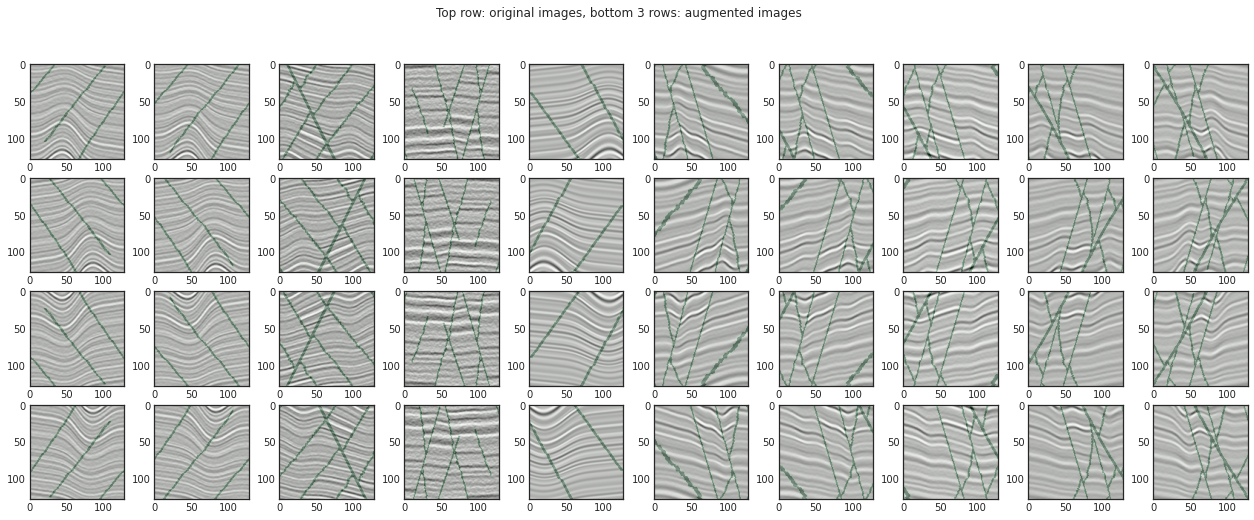

In [13]:
fig, axs = plt.subplots(4, 10, figsize=(22,8))
for i in range(10):
    axs[0][i].imshow(train_images[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(train_masks[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(train_images[int(len(train_images)/4 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(train_masks[int(len(train_masks)/4 + i)].squeeze(), cmap="Greens", alpha=0.3)
    axs[2][i].imshow(train_images[int(len(train_images)/2 + i)].squeeze(), cmap="Greys")
    axs[2][i].imshow(train_masks[int(len(train_masks)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
    axs[3][i].imshow(train_images[int(len(train_images)/4*3 + i)].squeeze(), cmap="Greys")
    axs[3][i].imshow(train_masks[int(len(train_masks)/4*3 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom 3 rows: augmented images")

In [14]:
print(train_images.shape, train_masks.shape)

(10400, 128, 128, 1) (10400, 128, 128, 1)


## Exercise: 
write your network. It can be a unet, or any other you would like to try.

In [15]:
#To get a beter model we should:
# - Use more filters and more layers
# - USe more convolutional layers (4blocks in this case)
# should I use costumized function for the metrics? how so?

def unet(input_size = (128,128,1)):

    inputs = Input(input_size)
    
    # YOUR CODE HERE #
    # Encoder layer 1 --> images 128
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs) #number of filters:6, size:3x3
    conv1 = BatchNormalization()(conv1) #input:conv1
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1) #number of filters:6, size:3x3
    conv1 = BatchNormalization()(conv1) #input:conv1
    conv1 = Dropout(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 

    # Encoder layer 2 --> images of 64x64 (because the Pooling was 2x2 of a image of 128)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1) #since the images here are smaller we can have more filters
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2) #since the images here are smaller we can have more filters
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2))(conv2) #3 more

    
    # Encoder layer 3 --> images of 32x32
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2) #since the images here are smaller we can have more filters
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3) #since the images here are smaller we can have more filters
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2))(conv3) #3 more
    
    # Encoder layer 4 --> images of 16x16
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3) #since the images here are smaller we can have more filters
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2))(conv4) #3 more

    
    # Center (compressed representation)
    # -> images 8x8
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.2)(conv5)


    # Decoder layer 1 --> back to image size 16x16
    up6 = Conv2DTranspose(512,2,strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    up6 = BatchNormalization()(up6)
    merge6 = concatenate([conv4,up6],axis=3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    
    # Decoder layer 2 --> back to image size 32x32
    up7 = Conv2DTranspose(256,2,strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization()(up7)
    merge7 = concatenate([conv3,up7],axis=3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)

    
    # Decoder layer 3 --> back to image size 64x64
    up8 = Conv2DTranspose(128,2,strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization()(up8)
    merge8 = concatenate([conv2,up8],axis=3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    
    # Decoder layer 4 --> back to image size 128x128
    up9 = Conv2DTranspose(64,2,strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    up9 = BatchNormalization()(up9)
    merge9 = concatenate([conv1,up9],axis=3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9=Dropout(0.2)(conv9)
    

    output = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = output)
    
    return model

Generating model:

In [16]:
model_type = "myunet"
model1 = unet()

model1.compile(
    loss = "binary_crossentropy", 
    optimizer = "adam",
    metrics = ["accuracy"])

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

### Training model:
use the path below to save your models in unique directories for testing. 

In [17]:
version = 1
save_model_name = f"./model/{model_type}_trained_v{version}.model"
save_model_name

'./model/myunet_trained_v1.model'

In [18]:
#Fitting the model:
monitor="val_accuracy"
early_stopping = EarlyStopping(monitor = monitor, patience = 30,  verbose = 1) #after patience="number of interations or epochs". If there's no changes after "patience" interatations it's gonna stop
model_checkpoint = ModelCheckpoint("my_model.model1", monitor = monitor, save_best_only = True, verbose = 1) #CHANGE HERE THE NAME OF MODEL I WANT TO RUN #"save_best_only= True --> ": only if the accuracy increases it's when is going to save a new version of the model
reduce_lr = ReduceLROnPlateau(monitor = monitor, factor = 0.5, patience = 7,min_lr = 0.0001, verbose = 1) #it reduces the learning rate by a factor of "factor"(so when factor = 0.5, 50% of the original value) and if also 

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


epochs = 100 #it was 10 before [inside the epochs we have the interations(run all the batch_size)]
batch_size = 20 #batch_size: size of training samples you use (number of images to do the training) #"batch_size = 20" -->so 20 images to do the training, and 20, and 20... until we have all 320 (total number of images)


t_model1_start = time.time()
#saving our data in "history"
history = model1.fit(train_images, train_masks,
                     validation_data = (validation_images, validation_masks), ##it was a list [] before, but since it's a taple we changed to ()
                     epochs = epochs, 
                     batch_size = batch_size, 
                     callbacks = [early_stopping, model_checkpoint, reduce_lr],
                     verbose = 1) #why not 2?
t_model1_end = time.time()
print(f"Run time = {(t_model1_end-t_model1_start)/3600} hours")

Epoch 1/100
520/520 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.9302
Epoch 00001: val_accuracy improved from -inf to 0.95437, saving model to my_model.model1
INFO:tensorflow:Assets written to: my_model.model1/assets
520/520 [==============================] - 81s 134ms/step - loss: 0.2170 - accuracy: 0.9302 - val_loss: 0.1316 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 2/100
520/520 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9643
Epoch 00002: val_accuracy improved from 0.95437 to 0.96199, saving model to my_model.model1
INFO:tensorflow:Assets written to: my_model.model1/assets
520/520 [==============================] - 68s 132ms/step - loss: 0.0978 - accuracy: 0.9643 - val_loss: 0.1095 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 3/100
520/520 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9671
Epoch 00003: val_accuracy improved from 0.96199 to 0.96396, saving model to my_model.model1
INFO:tensorflow:Assets wri

In [20]:
%tensorboard --logdir ./logs/fit

SyntaxError: ignored

# PART 2: prediction

In the second part, we load the model from disk and use it for prediction.\
If you have more than one model saved, choose the best.

In [21]:
version = 1
model_type = "myunet"
model_name = f"./model/{model_type}_trained_v{version}.model"
model = load_model(model_name)

OSError: ignored

In [ ]:
print(validation_images.shape)

In [ ]:
model.summary()

In [ ]:
preds_valid = model.predict(validation_images)

In [ ]:
preds_valid = preds_valid.reshape(-1, 128, 128)

In [ ]:
from random import randint
def plotImageTranspValid(file1, file2, file3, k, alpha1 = 0.2, alpha2 = 0.2):
    fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(18, 18))
    for i in range(k):
        for j in range(k):
            ind = randint(0,file1.shape[0]-1)
            ax[i,j].imshow(file1[ind], cmap='Greys')
            ax[i,j].imshow(file2[ind], cmap='Blues', alpha = alpha1)
            ax[i,j].imshow(file3[ind], cmap='Reds', alpha = alpha2)
            ax[i,j].set_axis_off()
    fig.subplots_adjust(wspace = -0.15, hspace = 0.02)
    plt.suptitle("Blue: faults, Red: prediction.")
    return(fig)

In [ ]:
fig = plotImageTranspValid(validation_images, validation_masks, preds_valid, k = 8, alpha1 = 0.2, alpha2 = 0.3)

### Select a better threshold

In [ ]:
import numpy as np

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
thresholds = np.linspace(0, 1, 50) #50 thresholds from 0 to 1
ious = np.array([iou_metric_batch(validation_masks, np.int32(preds_valid > threshold)) for threshold in thresholds]) #calculate the threshold and see which one gives the best IoU
#IoU=1 is really good prediction, IoU=0 is bad

In [ ]:
plt.plot(ious)

In [ ]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

In [ ]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

New predictions using best threshold:

In [ ]:
predictions = np.int32(preds_valid > threshold_best)

In [ ]:
plt.imshow(preds_valid[0])
plt.colorbar()

In [ ]:
plt.imshow(predictions[0])
plt.colorbar()

Define a function to plot

In [ ]:
def plotImageTransp(file1, file2, k, alpha = 0.2):
    fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(18, 18))
    for i in range(k):
        for j in range(k):
            ind = randint(0,file1.shape[0]-1)
            ax[i,j].imshow(file1[ind], cmap='Greys')
            ax[i,j].imshow(file2[ind], cmap='Purples', alpha = alpha)
            ax[i,j].set_axis_off()
    fig.subplots_adjust(wspace = -0.15, hspace = 0.02)
    return(fig)

In [ ]:
fig = plotImageTransp(validation_images, predictions, k = 8)